Universidade Federal de Santa Catarina<br>
Departamento de Engenharia Elétrica e Eletrônica<br>
EEL7514/EEL7513 - Introdução ao Aprendizado de Máquina
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bU}{\mathbf{U}}$
$\newcommand{\bu}{\mathbf{u}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\calS}{\mathcal{S}}$


# Exercício 9: Detecção de Anomalias e Sistemas de Recomendação

Neste exercício, você irá explorar duas aplicações de técnicas de aprendizado de máquina: estimação de densidade para detecção de anomalias, um problema de aprendizado não supervisionado; e um algoritmo de fatoração matricial para filtragem colaborativa em um sistema de recomendação.

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_mldata
from scipy.stats import multivariate_normal

def plot_data(X, outliers=None, mean=None, cov=None):
    plt.scatter(X[:,0], X[:,1], marker='x')
    plt.axis('square')
    plt.axis([0, 30, 0, 30])
    plt.gcf().set_size_inches(5, 5)
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (Mbit/s)');
    # circle outliers
    if outliers is not None:
        outliers = outliers > 0
        plt.scatter(X[outliers,0], X[outliers,1], c='none', marker='o', 
                    edgecolors='red', linewidths=2, s=100)
    # plot level curves corresponding to p = 10^-3, 10^-6, 10^-9, ...
    if mean is not None and cov is not None:
        X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
        XX = np.c_[X1.reshape(-1), X2.reshape(-1)]
        p = multivariate_normal(mean=mean, cov=cov).pdf(XX)
        p = p.reshape(X1.shape)
        plt.contour(X1, X2, -np.log10(p + np.finfo(np.float64).tiny), 
                    levels=3*np.arange(1, 11), cmap=plt.cm.Greens_r, zorder=-1)
    plt.show()

# Detecção de anomalias

## Conjunto de dados #1

O primeiro conjunto de dados possui como atributos o _throughput_ (Mbit/s) e a latência (ms) da resposta de cada servidor de uma rede, medidos em vários momentos durante seu funcionamento. O objetivo é detectar um comportamento anômalo. Você dispõe de um conjunto de treinamento não-rotulado $\bX$ e um conjunto de validação rotulado $(\bX_{val}, \by_{val})$. Note que o conjunto de treinamento não é garantidamente livre de amostras anômalas, i.e., provavelmente é um conjunto "contaminado".

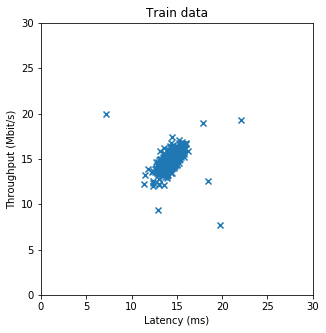

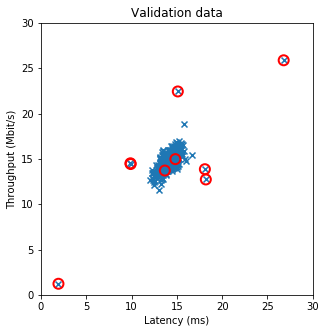

In [2]:
data = loadmat('data/anomaly1.mat')
X = data['X']
X_val, y_val = data['Xval'], data['yval'][:, 0]
plt.title('Train data')
plot_data(X)
plt.title('Validation data')
plot_data(X_val, y_val)

Utilize um modelo gaussiano multivariável para ajustar o conjunto de treinamento, i.e., estime a média e a matriz de covariância dos dados. Trace curvas de nível da densidade de probabilidade usando a função `plot_data(X, None, mean, cov)`. Para estimar a média e covariância, utilize as funções `np.mean()` e `np.cov()` (configure corretamente a orientação dos eixos).

Para fins de comparação, realize também uma estimação da matriz de covariância sob a hipótese de independência, i.e., estime a variância de cada dimensão independentemente e utilize esses valores para produzir uma matriz de covariância diagonal. Para isso, utilize a função `np.var()`. Qual estimação parece mais adequada? Por quê?

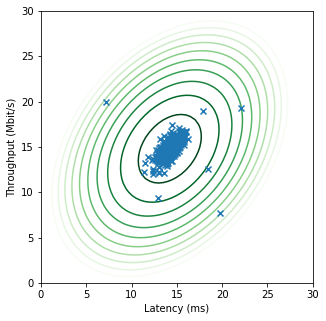

Para realizar a detecção de anomalias, é necessário definir um limiar $\epsilon$ de tal forma que uma amostra $\bx$ é classificada como anômala quando $p(\bx) < \epsilon$. Não há um valor correto ou uma forma única de escolher este limiar; em última análise, trata-se de uma escolha arbitrária e que depende do modelo. Caso esteja disponível um conjunto de validação, uma forma objetiva de escolher o limiar é escolher aquele que maximiza uma métrica de classificação sobre o conjunto de validação. Naturalmente, a métrica deve ser robusta ao desbalanceamento do conjunto.

Inicialmente, escolha alguns valores de $\epsilon$, realize a predição no conjunto de **treinamento** e marque as anomalias no gráfico usando a função `plot_data(X, y_pred, mean, cov)`.

Em seguida, implemente uma função `select_threshold(p, y)` que tem como entrada um vetor `p` de probabilidades das amostras (estimadas segundo o modelo ajustado) e um vetor `y` com seus respectivos rótulos, e que retorna o valor de $\epsilon$ que maximiza o score F1 no conjunto fornecido, bem como o valor de F1 obtido. Utilize essa função no conjunto de **validação** para determinar $\epsilon$ e F1. Com este valor de limiar, realize a predição no conjunto de **treinamento** e novamente marque as anomalias no gráfico.

### Dicas de implementação

- Utilize a função `scipy.stats.multivariate_normal(mean, cov)` para definir o modelo e o respectivo método `.pdf()` para calcular a densidade de probabilidade.
- Utilize a função `sklearn.metrics.f1_score` para calcular o score F1.



In [16]:
print('epsilon =', epsilon)
print('F1 =', F1)

epsilon = 0.00012459071573165978
F1 = 0.8750000000000001


Agora, realize a detecção de anomalias utilizando a função `sklearn.covariance.EllipticEnvelope` e compare os resultados obtidos. Esta função assume o mesmo modelo probabilístico, porém com duas diferenças:
- A estimação de variância é robusta a outliers;
- A predição é feita usando um valor de $\epsilon$ calculado automaticamente de tal forma a obter uma determinada fração de outliers, dada pelo parâmetro `contamination`.

Além disso, a predição considera a codificação -1 para representar uma amostra anômala e 1 para uma amostra normal.
Os parâmetros estimados pelo modelo (para uso pela função `plot_data`) ficam armazenados em `.location_` e `.covariance_`.

## Conjunto de dados #2

O próximo conjunto de dados possui $n=11$ atributos e um maior número de amostras de treinamento. Para uma maior variabilidade, também é feita uma transformação linear aleatória do espaço (correspondendo a rotações, reflexões e escalonamentos) através de uma matriz $\bT$.

Repita os itens anteriores comparando os 3 tipos de modelo gaussiano:
- Estimação de covariância completa;
- Estimação de covariância diagonal;
- Modelo EllipticEnvelope() do sklearn.

Desta vez não será possível visualizar a densidade de probabilidade em um espaço 11-dimensional, mas o score F1 no conjunto de validação pode ser calculado. Determine também o número de anomalias encontradas (no conjunto de treinamento) em cada modelo.

Em particular, na comparação com o método de estimação da covariância diagonal, experimente utilizar vários estados diferentes do gerador de números aleatórios. O que você observa? Explique.

In [4]:
data = loadmat('data/anomaly2.mat')
X = data['X']
X_val, y_val = data['Xval'], data['yval'][:, 0]
n = X.shape[1]
T = np.random.RandomState(0).randn(n,n)
X = X @ T
X_val = X_val @ T
print(X.shape, X_val.shape)

(1000, 11) (100, 11)


# Sistemas de recomendação

Instale a biblioteca [Surprise](http://surpriselib.com/) e mostre um exemplo de utilização do algoritmo de filtragem colaborativa denominado [SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) sobre o conjunto de dados [MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/100k/), o qual consiste de 100000 avaliações de filmes em uma escala de 1 a 5, feitas por 943 usuários sobre 1682 filmes. Note que a versão [_unbiased_](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#unbiased-note) do algoritmo (`biased=False`) corresponde ao algoritmo descrito em sala.



